In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import math
from matplotlib.colors import ListedColormap
import seaborn as sns

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


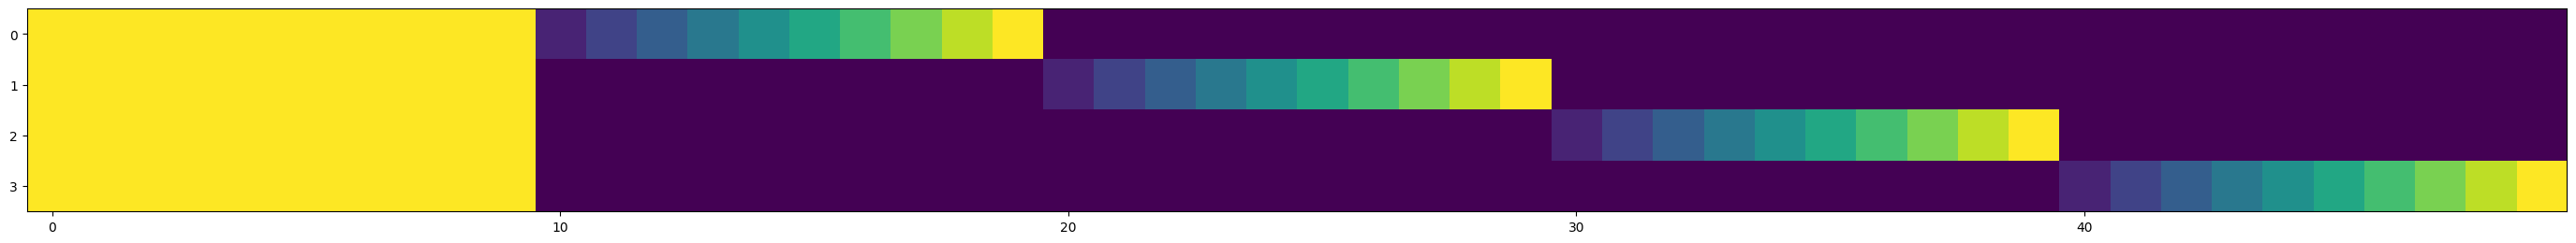

In [2]:
seq_class = []
total_tokens = 50
offset = 10 

for i in range(4):
    temp = np.zeros(total_tokens)
    temp[:offset] = 1
    temp[(i+1)*offset:((i+2)*offset)] = np.arange(0.1,1.1,0.1)
    temp = temp/sum(temp)
    seq_class.append(temp)
    assert(sum(seq_class[i])==1)
plt.figure(figsize=(35,10))
plt.imshow(np.vstack(seq_class))
    
def sample_sequence(next_token,seq_len):
    '''
    function to sample a sequence based on p(l|m,n) for given m and n.
    '''
    query_tokens = [5,6,7,8]
    next_tokens = [1,2,3,4]
    if next_token==next_tokens[0]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[0],size=seq_len-2)
        seq = np.append(context_tokens,[query_tokens[0],next_token])
    if next_token==next_tokens[1]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[1],size=seq_len-2)
        seq = np.append(context_tokens,[query_tokens[1],next_token])
    if next_token==next_tokens[2]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[2],size=seq_len-2)
        seq = np.append(context_tokens,[query_tokens[2],next_token])
    if next_token==next_tokens[3]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[3],size=seq_len-2)
        seq = np.append(context_tokens,[query_tokens[3],next_token])
    return seq

def generate_data(batch_size,seq_len):
    batch_of_seq = []
    next_tokens = [1,2,3,4]
    for i in range(batch_size):
        next_token = np.random.choice(next_tokens,p=[0.25]*4)
        generated_seq = sample_sequence(next_token,seq_len)
        batch_of_seq.append(torch.tensor(generated_seq))
    return torch.vstack(batch_of_seq)


def analyse_model(model,batch_size,seq_len):
    test_inputs = generate_data(batch_size,seq_len)
    tinputs,tlabels  = test_inputs[:,:-1].to(device),test_inputs[:,-1].to(device)
    
    model.eval()
    with torch.no_grad():
        model_output,model_attention = model(tinputs)
    #model_output = nn.Softmax(dim=1)(model_output)

    common_tokens_attn = []
    distinct_tokens_attn = []
    for i in range(batch_size):
        indices_1 = torch.logical_and(tinputs[i]>=0,tinputs[i]<10)
        indices_2 = torch.logical_and(tinputs[i]>=10,tinputs[i]<50)
        common_tokens_attn.append(sum(model_attention[i][indices_1]).item())
        distinct_tokens_attn.append(sum(model_attention[i][indices_2]).item())
    return np.mean(common_tokens_attn),np.mean(distinct_tokens_attn)


class Net_p1(nn.Module):
    def __init__(self):
        super(Net_p1,self).__init__()
        self.key_layer = nn.Linear(50,50,bias=False)
        self.query_layer = nn.Linear(50,50,bias=False)
        self.value_layer = nn.Linear(50,50,bias=False)
        self.prediction_layer = nn.Linear(50,50,bias=False)
        
        #self.key_query_layer.weight = nn.Parameter(torch.zeros(50,50))
        self.key_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.query_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.value_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.prediction_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
    def forward(self,x):
        batch,seq_len,vocab_size = x.shape
        
        key = self.key_layer(x)
        query = torch.unsqueeze(self.query_layer(x[:,-1]),dim=1)
        
        #print(key.shape,query.shape)
        scores = (query@key.transpose(-2,-1))*(1/math.sqrt(key.size(-1)))
        
        
        
        
        attn = nn.Softmax(dim=-1)(scores)
        x1 = self.value_layer(x)
        context =torch.matmul(attn,x1)
    
        output = self.prediction_layer(context)
        #print(output.shape)
        return output[:,0,:],attn[:,0,:]



In [3]:
def generate_heatmap(model,epoch_no):
    model.eval()
    attn_values = []
    prediction  = []
    with torch.no_grad():
        running_loss = 0.0
        for j in range(200):
            data = generate_data(batch_size,seq_len)
            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            indices = inputs>9
            inputs = F.one_hot(inputs,num_classes=50).float()
            outputs,attn  = model(inputs)
            #print(outputs.shape)
            outputs = nn.Softmax(dim=1)(outputs)
            #print(outputs[np.arange(128),labels])
            #print(outputs.shape)

            for i in range(outputs.shape[0]):
                attn_values.append(sum(attn[i][indices[i]]).item())
                prediction.append(outputs[i,labels[i]].item())
    return attn_values,prediction

In [ ]:
n_epochs = 1000
n_batches = 100

batch_size= 32 # actual batch size is times 4 here 128
seq_len = 64

n_seeds = [1234,1235,1236,1237,1238]

Attn_Values  = []
Prediction_Values = []
#deltas_list = []
for seed in n_seeds:
    torch.manual_seed(seed)
    model = Net_p1().to(device)
    criterion = nn.CrossEntropyLoss()
    # Define parameter groups
    optimizer = torch.optim.SGD([
        {'params': model.key_layer.parameters(), 'lr': 2e-1},
        {'params': model.query_layer.parameters(), 'lr': 2e-1},
        {'params': model.value_layer.parameters(), 'lr': 1e-2},
        {'params': model.prediction_layer.parameters(), 'lr': 1e-2}])

    running_loss = 0.0

    common_token_attn = []
    distinct_token_attn = []
    #deltas = []
    epsilon = 1e-8
    #generate_heatmap(model,0)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        for j in range(n_batches):
            data = generate_data(batch_size,seq_len)

            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            inputs = F.one_hot(inputs,num_classes=50).float()

            optimizer.zero_grad()

            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
        if (running_loss/n_batches)<=0.001:
            break
        if (epoch+1)%100 ==0:
            print(f'[{epoch+1},{j+1:5d}] loss:{running_loss/(100*n_batches):.3f}')
            running_loss = 0.0
            #generate_heatmap(model,epoch+1)
    print("Finished Training")
    #deltas_list.append(deltas)
    attn,preds = generate_heatmap(model,epoch+1)
    Attn_Values.append(attn)
    Prediction_Values.append(preds)

In [ ]:
correct = 0 
total = 0
model.eval()
with torch.no_grad():
    running_loss = 0.0 
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')

In [ ]:
attn_values_1 = np.mean(Attn_Values,axis=0)
prediction_1 = np.mean(Prediction_Values,axis=0)

In [ ]:
bin_edges = [np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), np.array([0, 0.2, 0.4, 0.6, 0.8, 1])]

num = 64
histograms = []
for attn_values, prediction in zip(Attn_Values, Prediction_Values):
    hist, _, _ = np.histogram2d(attn_values, prediction, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("params_increased_fafo_2.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(std_hist_norm, dtype=object)
for i in range(std_hist_norm.shape[0]):
    for j in range(std_hist_norm.shape[1]):
        annot_array[i, j] = f"±{std_hist_norm[i, j]:.1f}"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(std_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params1_increased_lr_qk_std.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# torch.manual_seed(1234)
# model = Net_p1().to(device)
model.eval()
attn_values = []
prediction  = []
with torch.no_grad():
    running_loss = 0.0
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        indices = inputs>9
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        #print(outputs.shape)
        outputs = nn.Softmax(dim=1)(outputs)
        #print(outputs[np.arange(128),labels])
        
        for i in range(attn.shape[0]):
            attn_values.append(sum(attn[i][indices[i]]).item())
            prediction.append(outputs[i,labels[i]].item())

In [ ]:
attn_values = np.array(attn_values)[None,:]
prediction = np.array(prediction)[None,:]

In [ ]:
num = 160
histograms = []
for attn, pred in zip(attn_values, prediction):
    hist, _, _ = np.histogram2d(attn, pred, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}" #\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("params_increased_fafo_test.pdf", bbox_inches='tight')
plt.show()


# increasing lr


In [ ]:
n_epochs = 2000
n_batches = 100

batch_size= 32 # actual batch size is times 4 here 128
seq_len = 64

n_seeds = [1234,1235,1236,1237,1238]

Attn_Values  = []
Prediction_Values = []
#deltas_list = []



# total number of training steps
total_steps = n_epochs * n_batches

# def increasing_lr_lambda(step):
#     progress = step / total_steps
#     scale = 1.0 + 9.0 * (progress ** 0.1) 
#     return scale


for seed in n_seeds:
    torch.manual_seed(seed)
    model = Net_p1().to(device)
    criterion = nn.CrossEntropyLoss()
    # Define parameter groups
    optimizer = torch.optim.SGD([
        {'params': model.key_layer.parameters(), 'lr': 1e-2},
        {'params': model.query_layer.parameters(), 'lr': 1e-2},
        {'params': model.value_layer.parameters(), 'lr': 1e-2},
        {'params': model.prediction_layer.parameters(), 'lr': 1e-2}])
    
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=[lambda step: 1 + (40 - 1) * step / total_steps,  # key_layer
                   lambda step: 1 + (40 - 1) * step / total_steps, # query_layer
                   lambda step: 1.0,      # value_layer
                   lambda step: 1.0       # prediction_layer
                  ])

    running_loss = 0.0

    common_token_attn = []
    distinct_token_attn = []
    #deltas = []
    epsilon = 1e-8
    #generate_heatmap(model,0)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        # Print current learning rates for debugging
        #for i, param_group in enumerate(optimizer.param_groups):
        #    print(f"Group {i} LR: {param_group['lr']:.6f}")
        for j in range(n_batches):
            data = generate_data(batch_size,seq_len)

            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            inputs = F.one_hot(inputs,num_classes=50).float()

            optimizer.zero_grad()

            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss +=loss.item()
#         if (running_loss/n_batches)<=0.001:
#             break
        if (epoch+1)%100 ==0:
            print(f'[{epoch+1},{j+1:5d}] loss:{running_loss/(100*n_batches):.3f}')
            running_loss = 0.0
            #generate_heatmap(model,epoch+1)
    print("Finished Training")
    #deltas_list.append(deltas)
    attn,preds = generate_heatmap(model,epoch+1)
    Attn_Values.append(attn)
    Prediction_Values.append(preds)

In [ ]:
correct = 0 
total = 0
model.eval()
with torch.no_grad():
    running_loss = 0.0 
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')



In [ ]:
attn_values_1 = np.mean(Attn_Values,axis=0)
prediction_1 = np.mean(Prediction_Values,axis=0)

In [ ]:
bin_edges = [np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), np.array([0, 0.2, 0.4, 0.6, 0.8, 1])]

num = 64
histograms = []
for attn_values, prediction in zip(Attn_Values, Prediction_Values):
    hist, _, _ = np.histogram2d(attn_values, prediction, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("params_increasing_fafo.pdf", bbox_inches='tight')
plt.show()





# CACO Setting

### Increased Learning Rate

In [13]:
class Net_CACO(nn.Module):
    def __init__(self):
        super(Net_CACO, self).__init__()
        self.key_layer = nn.Linear(50, 50, bias=False)
        self.prediction_layer = nn.Linear(50, 50, bias=False)

    def forward(self, x):
        # x: (batch, seq_len, vocab_size)
        key = self.key_layer(x)  # (B, T, D)
        query = x[:, -1:, :]     # (B, 1, D)

        # Attention scores: (B, 1, D) x (B, D, T) -> (B, 1, T)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(key.size(-1))
        attn = F.softmax(scores, dim=-1)  # (B, 1, T)

        # Context: (B, 1, T) x (B, T, D) -> (B, 1, D)
        context = torch.matmul(attn, x)
        output = self.prediction_layer(context)  # (B, 1, D)

        return output.squeeze(1), attn.squeeze(1)


In [42]:
n_epochs = 2000
n_batches = 100

batch_size = 32
seq_len = 128

n_seeds = [1234,1235,1236,1237,1238]

Attn_Values = []
Prediction_Values = []

for seed in n_seeds:
    torch.manual_seed(seed)
    model = Net_CACO().to(device)
    
    criterion  = nn.CrossEntropyLoss()
    
    lr_query_key = 0.05 # 0.02, 0.03,0.04,0.05,0.1
    
    lr_prediction = 0.01
    
    optimizer = optim.SGD([
        {"params":model.key_layer.parameters(), "lr":lr_query_key},
        {"params":model.prediction_layer.parameters(),"lr":lr_prediction}])
    
    
    running_loss =0.0
    
    common_token_attn = []
    distinct_token_attn = []
    
    
    
    epsilon = 1e-8
    
    for epoch in tqdm(range(n_epochs)):
        model.train()
        
        for j in range(n_batches):
            
            data = generate_data(batch_size,seq_len)
            
            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            inputs = F.one_hot(inputs,num_classes=50).float()
            
            
            optimizer.zero_grad()
            
            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss +=loss.item()
        if (epoch+1)%100 ==0:
            print(f'[{epoch+1},{j+1:5d}] loss:{running_loss/(100*n_batches):.3f}')
            running_loss = 0.0
            #generate_heatmap(model,epoch+1)
    print("Finished Training")
    #deltas_list.append(deltas)
    attn,preds = generate_heatmap(model,epoch+1)
    Attn_Values.append(attn)
    Prediction_Values.append(preds)

  5%|██                                      | 100/2000 [00:35<09:57,  3.18it/s]

[100,  100] loss:3.284


 10%|████                                    | 200/2000 [01:09<09:52,  3.04it/s]

[200,  100] loss:2.212


 15%|██████                                  | 300/2000 [01:43<09:44,  2.91it/s]

[300,  100] loss:1.466


 20%|████████                                | 400/2000 [02:17<08:54,  2.99it/s]

[400,  100] loss:0.928


 25%|██████████                              | 500/2000 [02:50<08:28,  2.95it/s]

[500,  100] loss:0.493


 30%|████████████                            | 600/2000 [03:24<07:46,  3.00it/s]

[600,  100] loss:0.216


 35%|██████████████                          | 700/2000 [03:58<07:52,  2.75it/s]

[700,  100] loss:0.101


 40%|████████████████                        | 800/2000 [04:33<06:42,  2.98it/s]

[800,  100] loss:0.056


 45%|██████████████████                      | 900/2000 [05:07<06:12,  2.96it/s]

[900,  100] loss:0.036


 50%|███████████████████▌                   | 1000/2000 [05:41<05:39,  2.94it/s]

[1000,  100] loss:0.026


 55%|█████████████████████▍                 | 1100/2000 [06:14<04:54,  3.06it/s]

[1100,  100] loss:0.020


 60%|███████████████████████▍               | 1200/2000 [06:47<04:23,  3.03it/s]

[1200,  100] loss:0.016


 65%|█████████████████████████▎             | 1300/2000 [07:20<03:44,  3.12it/s]

[1300,  100] loss:0.013


 70%|███████████████████████████▎           | 1400/2000 [07:54<03:35,  2.78it/s]

[1400,  100] loss:0.011


 75%|█████████████████████████████▎         | 1500/2000 [08:28<02:49,  2.95it/s]

[1500,  100] loss:0.010


 80%|███████████████████████████████▏       | 1600/2000 [09:03<02:10,  3.06it/s]

[1600,  100] loss:0.008


 85%|█████████████████████████████████▏     | 1700/2000 [09:39<01:46,  2.81it/s]

[1700,  100] loss:0.008


 90%|███████████████████████████████████    | 1800/2000 [10:14<01:08,  2.92it/s]

[1800,  100] loss:0.007


 95%|█████████████████████████████████████  | 1900/2000 [10:50<00:32,  3.06it/s]

[1900,  100] loss:0.006


100%|███████████████████████████████████████| 2000/2000 [11:26<00:00,  2.91it/s]

[2000,  100] loss:0.006
Finished Training



  5%|██                                      | 100/2000 [00:35<10:49,  2.92it/s]

[100,  100] loss:3.284


 10%|████                                    | 200/2000 [01:11<10:22,  2.89it/s]

[200,  100] loss:2.212


 15%|██████                                  | 300/2000 [01:48<11:54,  2.38it/s]

[300,  100] loss:1.469


 20%|████████                                | 400/2000 [02:23<09:37,  2.77it/s]

[400,  100] loss:0.946


 25%|██████████                              | 500/2000 [02:58<08:16,  3.02it/s]

[500,  100] loss:0.542


 30%|████████████                            | 600/2000 [03:34<08:04,  2.89it/s]

[600,  100] loss:0.269


 35%|██████████████                          | 700/2000 [04:10<07:51,  2.76it/s]

[700,  100] loss:0.133


 40%|████████████████                        | 800/2000 [04:45<06:51,  2.92it/s]

[800,  100] loss:0.074


 45%|██████████████████                      | 900/2000 [05:20<06:26,  2.85it/s]

[900,  100] loss:0.047


 50%|███████████████████▌                   | 1000/2000 [05:56<06:35,  2.53it/s]

[1000,  100] loss:0.033


 55%|█████████████████████▍                 | 1100/2000 [06:29<04:47,  3.14it/s]

[1100,  100] loss:0.024


 60%|███████████████████████▍               | 1200/2000 [07:01<04:23,  3.04it/s]

[1200,  100] loss:0.019


 65%|█████████████████████████▎             | 1300/2000 [07:36<03:49,  3.05it/s]

[1300,  100] loss:0.016


 70%|███████████████████████████▎           | 1400/2000 [08:09<03:20,  3.00it/s]

[1400,  100] loss:0.013


 75%|█████████████████████████████▎         | 1500/2000 [08:42<02:38,  3.15it/s]

[1500,  100] loss:0.011


 80%|███████████████████████████████▏       | 1600/2000 [09:15<02:05,  3.20it/s]

[1600,  100] loss:0.010


 85%|█████████████████████████████████▏     | 1700/2000 [09:48<01:40,  2.98it/s]

[1700,  100] loss:0.009


 90%|███████████████████████████████████    | 1800/2000 [10:21<01:08,  2.93it/s]

[1800,  100] loss:0.008


 95%|█████████████████████████████████████  | 1900/2000 [10:56<00:36,  2.74it/s]

[1900,  100] loss:0.007


100%|███████████████████████████████████████| 2000/2000 [11:30<00:00,  2.90it/s]

[2000,  100] loss:0.006
Finished Training



  5%|██                                      | 100/2000 [00:35<10:38,  2.98it/s]

[100,  100] loss:3.286


 10%|████                                    | 200/2000 [01:10<10:25,  2.88it/s]

[200,  100] loss:2.214


 15%|██████                                  | 300/2000 [01:45<09:21,  3.03it/s]

[300,  100] loss:1.469


 20%|████████                                | 400/2000 [02:19<08:56,  2.98it/s]

[400,  100] loss:0.942


 25%|██████████                              | 500/2000 [02:53<08:06,  3.08it/s]

[500,  100] loss:0.531


 30%|████████████                            | 600/2000 [03:28<08:47,  2.65it/s]

[600,  100] loss:0.254


 35%|██████████████                          | 700/2000 [04:05<07:54,  2.74it/s]

[700,  100] loss:0.122


 40%|████████████████                        | 800/2000 [04:40<07:10,  2.79it/s]

[800,  100] loss:0.068


 45%|██████████████████                      | 900/2000 [05:14<06:16,  2.92it/s]

[900,  100] loss:0.043


 50%|███████████████████▌                   | 1000/2000 [05:48<05:51,  2.84it/s]

[1000,  100] loss:0.030


 55%|█████████████████████▍                 | 1100/2000 [06:23<05:45,  2.60it/s]

[1100,  100] loss:0.023


 60%|███████████████████████▍               | 1200/2000 [07:00<04:40,  2.85it/s]

[1200,  100] loss:0.018


 65%|█████████████████████████▎             | 1300/2000 [07:34<03:46,  3.09it/s]

[1300,  100] loss:0.015


 70%|███████████████████████████▎           | 1400/2000 [08:10<03:54,  2.56it/s]

[1400,  100] loss:0.012


 75%|█████████████████████████████▎         | 1500/2000 [08:45<02:48,  2.98it/s]

[1500,  100] loss:0.011


 80%|███████████████████████████████▏       | 1600/2000 [09:21<02:19,  2.87it/s]

[1600,  100] loss:0.009


 85%|█████████████████████████████████▏     | 1700/2000 [09:56<01:40,  2.98it/s]

[1700,  100] loss:0.008


 90%|███████████████████████████████████    | 1800/2000 [10:31<01:07,  2.97it/s]

[1800,  100] loss:0.007


 95%|█████████████████████████████████████  | 1900/2000 [11:07<00:40,  2.49it/s]

[1900,  100] loss:0.007


100%|███████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]

[2000,  100] loss:0.006
Finished Training



  5%|██                                      | 100/2000 [00:35<11:08,  2.84it/s]

[100,  100] loss:3.277


 10%|████                                    | 200/2000 [01:12<11:20,  2.65it/s]

[200,  100] loss:2.209


 15%|██████                                  | 300/2000 [01:48<10:36,  2.67it/s]

[300,  100] loss:1.469


 20%|████████                                | 400/2000 [02:24<08:47,  3.03it/s]

[400,  100] loss:0.952


 25%|██████████                              | 500/2000 [02:59<08:57,  2.79it/s]

[500,  100] loss:0.555


 30%|████████████                            | 600/2000 [03:33<08:17,  2.81it/s]

[600,  100] loss:0.285


 35%|██████████████                          | 700/2000 [04:07<07:33,  2.87it/s]

[700,  100] loss:0.145


 40%|████████████████                        | 800/2000 [04:43<07:22,  2.71it/s]

[800,  100] loss:0.082


 45%|██████████████████                      | 900/2000 [05:19<07:40,  2.39it/s]

[900,  100] loss:0.053


 50%|███████████████████▌                   | 1000/2000 [05:55<06:04,  2.75it/s]

[1000,  100] loss:0.037


 55%|█████████████████████▍                 | 1100/2000 [06:33<05:39,  2.65it/s]

[1100,  100] loss:0.027


 60%|███████████████████████▍               | 1200/2000 [07:09<05:03,  2.63it/s]

[1200,  100] loss:0.021


 65%|█████████████████████████▎             | 1300/2000 [07:45<04:11,  2.78it/s]

[1300,  100] loss:0.017


 70%|███████████████████████████▎           | 1400/2000 [08:21<03:46,  2.65it/s]

[1400,  100] loss:0.014


 75%|█████████████████████████████▎         | 1500/2000 [08:58<03:13,  2.58it/s]

[1500,  100] loss:0.012


 80%|███████████████████████████████▏       | 1600/2000 [09:32<02:17,  2.91it/s]

[1600,  100] loss:0.011


 85%|█████████████████████████████████▏     | 1700/2000 [10:06<01:46,  2.80it/s]

[1700,  100] loss:0.009


 90%|███████████████████████████████████    | 1800/2000 [10:39<01:01,  3.23it/s]

[1800,  100] loss:0.008


 95%|█████████████████████████████████████  | 1900/2000 [11:14<00:34,  2.88it/s]

[1900,  100] loss:0.008


100%|███████████████████████████████████████| 2000/2000 [11:50<00:00,  2.82it/s]

[2000,  100] loss:0.007
Finished Training



  5%|██                                      | 100/2000 [00:35<11:38,  2.72it/s]

[100,  100] loss:3.280


 10%|████                                    | 200/2000 [01:08<09:40,  3.10it/s]

[200,  100] loss:2.205


 15%|██████                                  | 300/2000 [01:42<09:44,  2.91it/s]

[300,  100] loss:1.455


 20%|████████                                | 400/2000 [02:18<09:29,  2.81it/s]

[400,  100] loss:0.924


 25%|██████████                              | 500/2000 [02:55<08:27,  2.96it/s]

[500,  100] loss:0.519


 30%|████████████                            | 600/2000 [03:30<09:03,  2.57it/s]

[600,  100] loss:0.257


 35%|██████████████                          | 700/2000 [04:05<07:59,  2.71it/s]

[700,  100] loss:0.130


 40%|████████████████                        | 800/2000 [04:39<06:34,  3.04it/s]

[800,  100] loss:0.074


 45%|██████████████████                      | 900/2000 [05:11<05:54,  3.11it/s]

[900,  100] loss:0.048


 50%|███████████████████▌                   | 1000/2000 [05:44<05:35,  2.98it/s]

[1000,  100] loss:0.034


 55%|█████████████████████▍                 | 1100/2000 [06:17<05:01,  2.99it/s]

[1100,  100] loss:0.025


 60%|███████████████████████▍               | 1200/2000 [06:50<04:21,  3.06it/s]

[1200,  100] loss:0.020


 65%|█████████████████████████▎             | 1300/2000 [07:22<03:46,  3.09it/s]

[1300,  100] loss:0.016


 70%|███████████████████████████▎           | 1400/2000 [07:55<03:21,  2.97it/s]

[1400,  100] loss:0.014


 75%|█████████████████████████████▎         | 1500/2000 [08:28<02:43,  3.06it/s]

[1500,  100] loss:0.012


 80%|███████████████████████████████▏       | 1600/2000 [09:01<02:09,  3.09it/s]

[1600,  100] loss:0.010


 85%|█████████████████████████████████▏     | 1700/2000 [09:35<01:37,  3.09it/s]

[1700,  100] loss:0.009


 90%|███████████████████████████████████    | 1800/2000 [10:08<01:06,  3.03it/s]

[1800,  100] loss:0.008


 95%|█████████████████████████████████████  | 1900/2000 [10:41<00:32,  3.08it/s]

[1900,  100] loss:0.007


100%|███████████████████████████████████████| 2000/2000 [11:15<00:00,  2.96it/s]

[2000,  100] loss:0.007
Finished Training


In [43]:
correct = 0 
total = 0 
model.eval()
with torch.no_grad():
    running_loss = 0.0 
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')

loss:0.006
accuracy:1.000


In [44]:
attn_values_1 = np.mean(Attn_Values,axis=0)
prediction_1 = np.mean(Prediction_Values,axis=0)

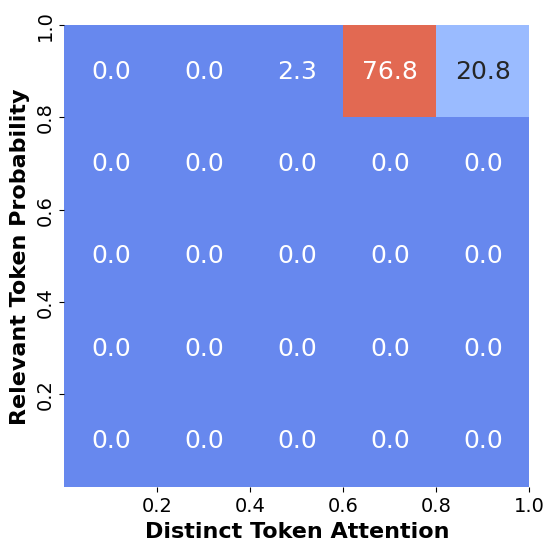

In [45]:
bin_edges = [np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), np.array([0, 0.2, 0.4, 0.6, 0.8, 1])]

num = 64
histograms = []
for attn_values, prediction in zip(Attn_Values, Prediction_Values):
    hist, _, _ = np.histogram2d(attn_values, prediction, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("params_increased_caco_1.pdf", bbox_inches='tight')
plt.show()





In [55]:
n_epochs = 2000
n_batches = 100

batch_size = 32
seq_len = 128

n_seeds = [1234,1235,1236,1237,1238]

Attn_Values = []
Prediction_Values = []

# total number of training steps
total_steps = n_epochs * n_batches



for seed in n_seeds:
    torch.manual_seed(seed)
    model = Net_CACO().to(device)
    
    criterion  = nn.CrossEntropyLoss()
    
    lr_query_key = 0.01
    
    lr_prediction = 0.01
    
    optimizer = optim.SGD([
        {"params":model.key_layer.parameters(), "lr":lr_query_key},
        {"params":model.prediction_layer.parameters(),"lr":lr_prediction}])
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=[lambda step: 1 + (10- 1) * step / total_steps,  # key_layer
                   lambda step: 1
                  ])

    
    
    running_loss =0.0
    
    common_token_attn = []
    distinct_token_attn = []
    
    
    
    for epoch in tqdm(range(n_epochs)):
        model.train()
        
        for j in range(n_batches):
            
            data = generate_data(batch_size,seq_len)
            
            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            inputs = F.one_hot(inputs,num_classes=50).float()
            
            
            optimizer.zero_grad()
            
            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss +=loss.item()
        if (epoch+1)%100 ==0:
            print(f'[{epoch+1},{j+1:5d}] loss:{running_loss/(100*n_batches):.3f}')
            running_loss = 0.0
            #generate_heatmap(model,epoch+1)
    print("Finished Training")
    #deltas_list.append(deltas)
    attn,preds = generate_heatmap(model,epoch+1)
    Attn_Values.append(attn)
    Prediction_Values.append(preds)

  5%|██                                      | 100/2000 [00:33<10:49,  2.93it/s]

[100,  100] loss:3.285


 10%|████                                    | 200/2000 [01:06<09:44,  3.08it/s]

[200,  100] loss:2.220


 15%|██████                                  | 300/2000 [01:39<08:56,  3.17it/s]

[300,  100] loss:1.500


 20%|████████                                | 400/2000 [02:12<08:44,  3.05it/s]

[400,  100] loss:1.035


 25%|██████████                              | 500/2000 [02:45<08:17,  3.02it/s]

[500,  100] loss:0.711


 30%|████████████                            | 600/2000 [03:18<07:43,  3.02it/s]

[600,  100] loss:0.468


 35%|██████████████                          | 700/2000 [03:51<06:56,  3.12it/s]

[700,  100] loss:0.293


 40%|████████████████                        | 800/2000 [04:24<06:49,  2.93it/s]

[800,  100] loss:0.178


 45%|██████████████████                      | 900/2000 [04:58<06:06,  3.00it/s]

[900,  100] loss:0.110


 50%|███████████████████▌                   | 1000/2000 [05:32<05:34,  2.99it/s]

[1000,  100] loss:0.071


 55%|█████████████████████▍                 | 1100/2000 [06:06<05:03,  2.96it/s]

[1100,  100] loss:0.048


 60%|███████████████████████▍               | 1200/2000 [06:39<04:16,  3.12it/s]

[1200,  100] loss:0.034


 65%|█████████████████████████▎             | 1300/2000 [07:11<03:50,  3.04it/s]

[1300,  100] loss:0.025


 70%|███████████████████████████▎           | 1400/2000 [07:45<03:18,  3.02it/s]

[1400,  100] loss:0.020


 75%|█████████████████████████████▎         | 1500/2000 [08:17<02:45,  3.03it/s]

[1500,  100] loss:0.016


 80%|███████████████████████████████▏       | 1600/2000 [08:51<02:11,  3.04it/s]

[1600,  100] loss:0.013


 85%|█████████████████████████████████▏     | 1700/2000 [09:25<01:48,  2.77it/s]

[1700,  100] loss:0.011


 90%|███████████████████████████████████    | 1800/2000 [09:58<01:07,  2.94it/s]

[1800,  100] loss:0.009


 95%|█████████████████████████████████████  | 1900/2000 [10:32<00:32,  3.05it/s]

[1900,  100] loss:0.008


100%|███████████████████████████████████████| 2000/2000 [11:06<00:00,  3.00it/s]

[2000,  100] loss:0.007
Finished Training



  5%|██                                      | 100/2000 [00:33<10:39,  2.97it/s]

[100,  100] loss:3.285


 10%|████                                    | 200/2000 [01:07<10:03,  2.98it/s]

[200,  100] loss:2.219


 15%|██████                                  | 300/2000 [01:40<09:33,  2.96it/s]

[300,  100] loss:1.496


 20%|████████                                | 400/2000 [02:14<08:51,  3.01it/s]

[400,  100] loss:1.032


 25%|██████████                              | 500/2000 [02:47<08:00,  3.12it/s]

[500,  100] loss:0.711


 30%|████████████                            | 600/2000 [03:20<07:37,  3.06it/s]

[600,  100] loss:0.475


 35%|██████████████                          | 700/2000 [03:54<07:08,  3.03it/s]

[700,  100] loss:0.304


 40%|████████████████                        | 800/2000 [04:27<06:40,  2.99it/s]

[800,  100] loss:0.192


 45%|██████████████████                      | 900/2000 [05:00<05:55,  3.10it/s]

[900,  100] loss:0.122


 50%|███████████████████▌                   | 1000/2000 [05:34<05:46,  2.89it/s]

[1000,  100] loss:0.080


 55%|█████████████████████▍                 | 1100/2000 [06:08<05:00,  2.99it/s]

[1100,  100] loss:0.055


 60%|███████████████████████▍               | 1200/2000 [06:42<04:36,  2.90it/s]

[1200,  100] loss:0.039


 65%|█████████████████████████▎             | 1300/2000 [07:15<03:53,  2.99it/s]

[1300,  100] loss:0.029


 70%|███████████████████████████▎           | 1400/2000 [07:49<03:22,  2.96it/s]

[1400,  100] loss:0.023


 75%|█████████████████████████████▎         | 1500/2000 [08:23<02:54,  2.86it/s]

[1500,  100] loss:0.018


 80%|███████████████████████████████▏       | 1600/2000 [08:57<02:09,  3.08it/s]

[1600,  100] loss:0.015


 85%|█████████████████████████████████▏     | 1700/2000 [09:30<01:40,  2.99it/s]

[1700,  100] loss:0.012


 90%|███████████████████████████████████    | 1800/2000 [10:03<01:06,  2.99it/s]

[1800,  100] loss:0.010


 95%|█████████████████████████████████████  | 1900/2000 [10:37<00:33,  3.01it/s]

[1900,  100] loss:0.009


100%|███████████████████████████████████████| 2000/2000 [11:11<00:00,  2.98it/s]

[2000,  100] loss:0.008
Finished Training



  5%|██                                      | 100/2000 [00:33<10:43,  2.95it/s]

[100,  100] loss:3.287


 10%|████                                    | 200/2000 [01:07<10:18,  2.91it/s]

[200,  100] loss:2.221


 15%|██████                                  | 300/2000 [01:40<09:07,  3.10it/s]

[300,  100] loss:1.499


 20%|████████                                | 400/2000 [02:13<08:52,  3.01it/s]

[400,  100] loss:1.035


 25%|██████████                              | 500/2000 [02:46<08:24,  2.97it/s]

[500,  100] loss:0.713


 30%|████████████                            | 600/2000 [03:19<07:56,  2.94it/s]

[600,  100] loss:0.474


 35%|██████████████                          | 700/2000 [03:51<06:53,  3.14it/s]

[700,  100] loss:0.302


 40%|████████████████                        | 800/2000 [04:25<06:43,  2.97it/s]

[800,  100] loss:0.189


 45%|██████████████████                      | 900/2000 [04:58<05:47,  3.16it/s]

[900,  100] loss:0.119


 50%|███████████████████▌                   | 1000/2000 [05:31<05:29,  3.03it/s]

[1000,  100] loss:0.077


 55%|█████████████████████▍                 | 1100/2000 [06:05<05:02,  2.98it/s]

[1100,  100] loss:0.053


 60%|███████████████████████▍               | 1200/2000 [06:39<04:26,  3.00it/s]

[1200,  100] loss:0.038


 65%|█████████████████████████▎             | 1300/2000 [07:11<03:50,  3.03it/s]

[1300,  100] loss:0.028


 70%|███████████████████████████▎           | 1400/2000 [07:44<03:15,  3.07it/s]

[1400,  100] loss:0.022


 75%|█████████████████████████████▎         | 1500/2000 [08:17<02:47,  2.99it/s]

[1500,  100] loss:0.017


 80%|███████████████████████████████▏       | 1600/2000 [08:50<02:12,  3.01it/s]

[1600,  100] loss:0.014


 85%|█████████████████████████████████▏     | 1700/2000 [09:24<01:38,  3.04it/s]

[1700,  100] loss:0.012


 90%|███████████████████████████████████    | 1800/2000 [09:57<01:06,  3.03it/s]

[1800,  100] loss:0.010


 95%|█████████████████████████████████████  | 1900/2000 [10:30<00:34,  2.90it/s]

[1900,  100] loss:0.008


100%|███████████████████████████████████████| 2000/2000 [11:04<00:00,  3.01it/s]

[2000,  100] loss:0.007
Finished Training



  5%|██                                      | 100/2000 [00:33<10:28,  3.02it/s]

[100,  100] loss:3.278


 10%|████                                    | 200/2000 [01:07<10:02,  2.99it/s]

[200,  100] loss:2.215


 15%|██████                                  | 300/2000 [01:41<09:29,  2.99it/s]

[300,  100] loss:1.497


 20%|████████                                | 400/2000 [02:14<08:46,  3.04it/s]

[400,  100] loss:1.035


 25%|██████████                              | 500/2000 [02:47<08:28,  2.95it/s]

[500,  100] loss:0.715


 30%|████████████                            | 600/2000 [03:20<08:01,  2.91it/s]

[600,  100] loss:0.478


 35%|██████████████                          | 700/2000 [03:53<07:12,  3.01it/s]

[700,  100] loss:0.309


 40%|████████████████                        | 800/2000 [04:27<06:56,  2.88it/s]

[800,  100] loss:0.196


 45%|██████████████████                      | 900/2000 [04:59<06:21,  2.88it/s]

[900,  100] loss:0.125


 50%|███████████████████▌                   | 1000/2000 [05:32<05:20,  3.12it/s]

[1000,  100] loss:0.083


 55%|█████████████████████▍                 | 1100/2000 [06:06<04:57,  3.02it/s]

[1100,  100] loss:0.057


 60%|███████████████████████▍               | 1200/2000 [06:39<04:30,  2.96it/s]

[1200,  100] loss:0.041


 65%|█████████████████████████▎             | 1300/2000 [07:13<03:46,  3.09it/s]

[1300,  100] loss:0.031


 70%|███████████████████████████▎           | 1400/2000 [07:47<03:25,  2.92it/s]

[1400,  100] loss:0.024


 75%|█████████████████████████████▎         | 1500/2000 [08:20<02:43,  3.05it/s]

[1500,  100] loss:0.019


 80%|███████████████████████████████▏       | 1600/2000 [08:53<02:22,  2.80it/s]

[1600,  100] loss:0.015


 85%|█████████████████████████████████▏     | 1700/2000 [09:27<01:39,  3.03it/s]

[1700,  100] loss:0.013


 90%|███████████████████████████████████    | 1800/2000 [10:01<01:07,  2.98it/s]

[1800,  100] loss:0.011


 95%|█████████████████████████████████████  | 1900/2000 [10:34<00:32,  3.04it/s]

[1900,  100] loss:0.009


100%|███████████████████████████████████████| 2000/2000 [11:08<00:00,  2.99it/s]

[2000,  100] loss:0.008
Finished Training



  5%|██                                      | 100/2000 [00:34<10:45,  2.94it/s]

[100,  100] loss:3.281


 10%|████                                    | 200/2000 [01:08<10:05,  2.97it/s]

[200,  100] loss:2.214


 15%|██████                                  | 300/2000 [01:42<09:45,  2.90it/s]

[300,  100] loss:1.490


 20%|████████                                | 400/2000 [02:16<08:46,  3.04it/s]

[400,  100] loss:1.024


 25%|██████████                              | 500/2000 [02:50<08:08,  3.07it/s]

[500,  100] loss:0.701


 30%|████████████                            | 600/2000 [03:24<07:38,  3.05it/s]

[600,  100] loss:0.463


 35%|██████████████                          | 700/2000 [03:57<07:10,  3.02it/s]

[700,  100] loss:0.295


 40%|████████████████                        | 800/2000 [04:30<06:27,  3.10it/s]

[800,  100] loss:0.185


 45%|██████████████████                      | 900/2000 [05:03<06:45,  2.71it/s]

[900,  100] loss:0.118


 50%|███████████████████▌                   | 1000/2000 [05:36<05:30,  3.03it/s]

[1000,  100] loss:0.078


 55%|█████████████████████▍                 | 1100/2000 [06:10<05:23,  2.78it/s]

[1100,  100] loss:0.054


 60%|███████████████████████▍               | 1200/2000 [06:43<04:17,  3.11it/s]

[1200,  100] loss:0.039


 65%|█████████████████████████▎             | 1300/2000 [07:16<03:48,  3.06it/s]

[1300,  100] loss:0.029


 70%|███████████████████████████▎           | 1400/2000 [07:50<03:29,  2.87it/s]

[1400,  100] loss:0.023


 75%|█████████████████████████████▎         | 1500/2000 [08:24<02:51,  2.91it/s]

[1500,  100] loss:0.018


 80%|███████████████████████████████▏       | 1600/2000 [08:58<02:10,  3.06it/s]

[1600,  100] loss:0.015


 85%|█████████████████████████████████▏     | 1700/2000 [09:32<01:36,  3.10it/s]

[1700,  100] loss:0.012


 90%|███████████████████████████████████    | 1800/2000 [10:05<01:04,  3.09it/s]

[1800,  100] loss:0.010


 95%|█████████████████████████████████████  | 1900/2000 [10:38<00:33,  2.99it/s]

[1900,  100] loss:0.009


100%|███████████████████████████████████████| 2000/2000 [11:11<00:00,  2.98it/s]

[2000,  100] loss:0.008
Finished Training


In [56]:
correct = 0 
total = 0
model.eval()
with torch.no_grad():
    running_loss = 0.0 
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')

loss:0.007
accuracy:1.000


In [57]:
attn_values_1 = np.mean(Attn_Values,axis=0)
prediction_1 = np.mean(Prediction_Values,axis=0)

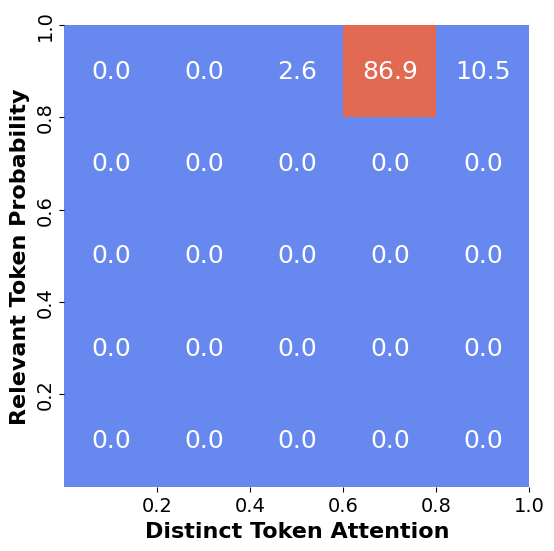

In [58]:
bin_edges = [np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), np.array([0, 0.2, 0.4, 0.6, 0.8, 1])]

num = 64
histograms = []
for attn_values, prediction in zip(Attn_Values, Prediction_Values):
    hist, _, _ = np.histogram2d(attn_values, prediction, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("params_increasing_caco.pdf", bbox_inches='tight')
plt.show()





In [50]:
2e-1

0.2